Loading data...
Demand data: 196513 rows
Temperature data: 220326 rows

Sample demand data:
        DATETIME  TOTALDEMAND REGIONID
0  1/1/2010 0:00      8038.00     NSW1
1  1/1/2010 0:30      7809.31     NSW1
2  1/1/2010 1:00      7483.69     NSW1
3  1/1/2010 1:30      7117.23     NSW1
4  1/1/2010 2:00      6812.03     NSW1

Sample temperature data:
    LOCATION       DATETIME  TEMPERATURE
0  Bankstown  1/1/2010 0:00         23.1
1  Bankstown  1/1/2010 0:01         23.1
2  Bankstown  1/1/2010 0:30         22.9
3  Bankstown  1/1/2010 0:50         22.7
4  Bankstown  1/1/2010 1:00         22.6

Preparing datetime formats for matching...

Aggregating temperature data to match demand timestamps...
Aggregated temperature data: 98075 rows

Matching demand with temperature data...
Matched data: 196149 rows

Basic statistics:
Correlation between Temperature and Demand: 0.1490

Create temperature ranges with approximately equal sample sizes:
Temperature ranges with equal sample sizes:
  TEMP_RAN

C:\Users\waseem\AppData\Local\Temp\ipykernel_18064\3158245480.py:132: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  demand_by_equal_temp = merged_df.groupby('TEMP_RANGE_EQUAL')['TOTALDEMAND'].agg(



Analysis complete. Visualizations saved.

Key Findings:
1. Overall correlation between temperature and demand: 0.1490
2. Quadratic regression equation: 7.3922x² + -226.2074x + 9551.9102
3. R-squared value for quadratic model: -4463.0909
4. Optimal temperature (minimum demand point): 15.30°C
5. Correlation in cold temperatures (below 15.30°C): 0.0346
6. Correlation in hot temperatures (above 15.30°C): 0.4436
7. Correlation in extreme temperatures:
   - Cold (<5°C): 0.0117
   - Hot (>30°C): 0.3878
8. Cold region quadratic model (T < 15.30°C):
   - Equation: -7.8373x² + 174.4628x + 7291.6949
   - R-squared: 0.0043
9. Hot region quadratic model (T > 15.30°C):
   - Equation: 9.3206x² + -285.4092x + 9828.3509
   - R-squared: 0.2285

Calculated demand at various temperatures using the quadratic model:
  At 0°C: 9551.91 MW
  At 5°C: 8605.68 MW
  At 10°C: 8029.06 MW
  At 15°C: 7822.05 MW
  At 20°C: 7984.66 MW
  At 25°C: 8516.88 MW
  At 30°C: 9418.71 MW
  At 35°C: 10690.15 MW

This analysis qua

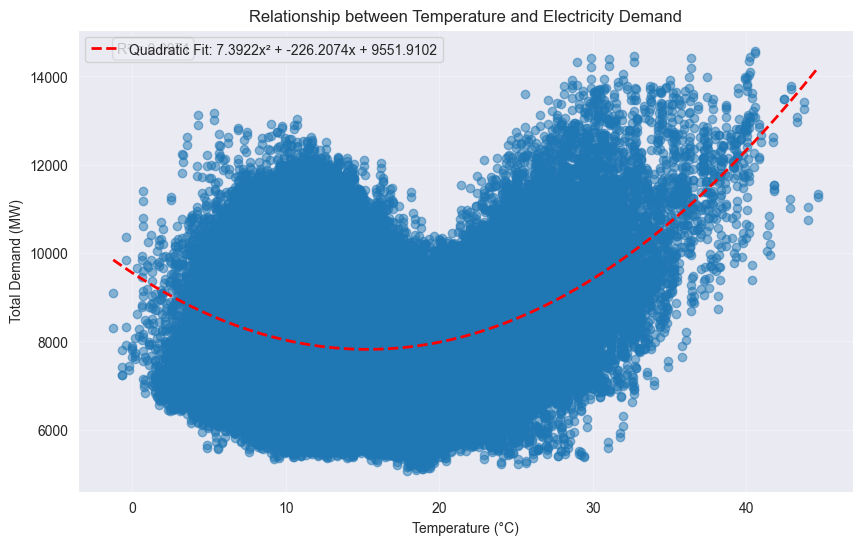

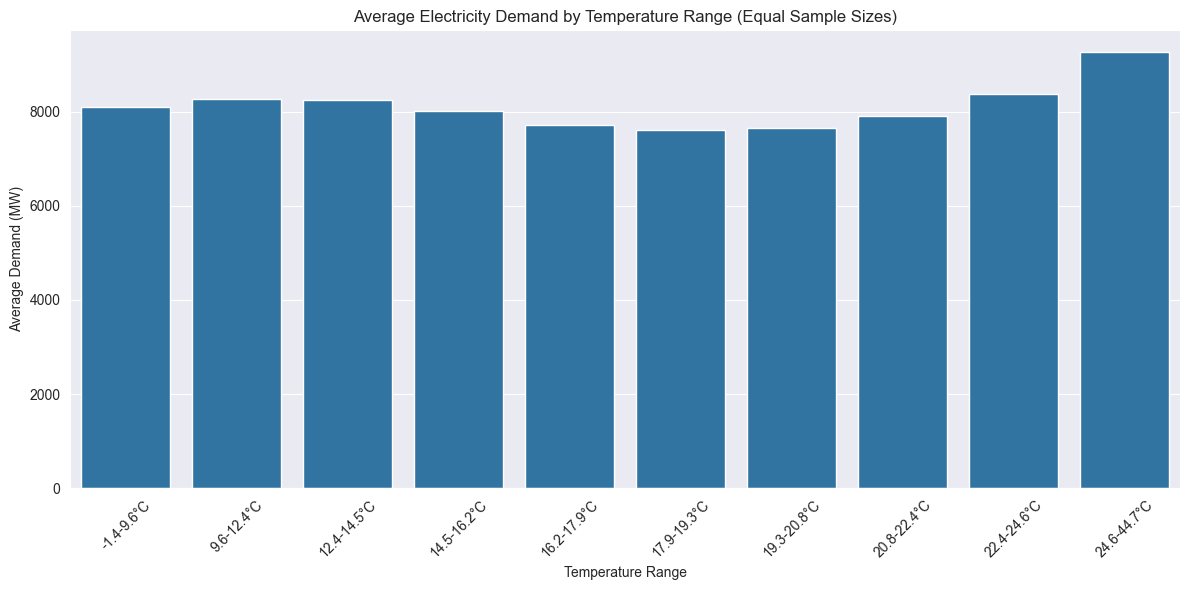

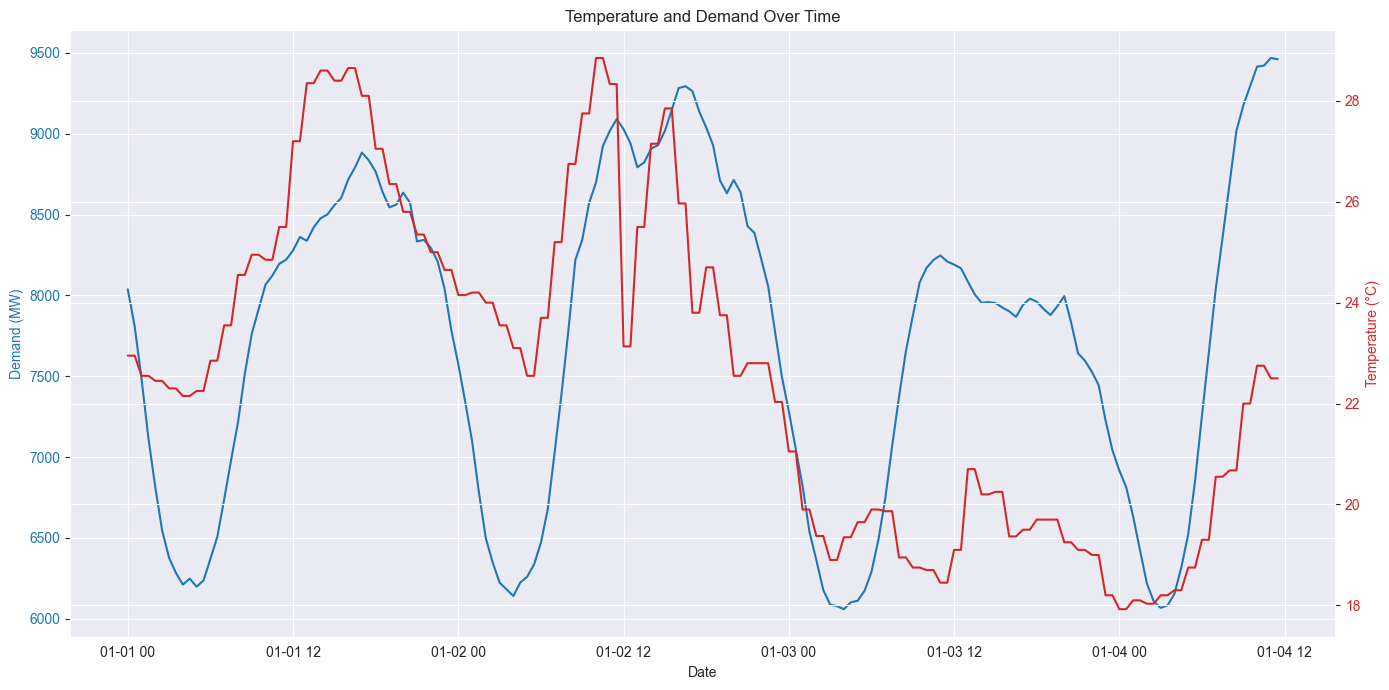

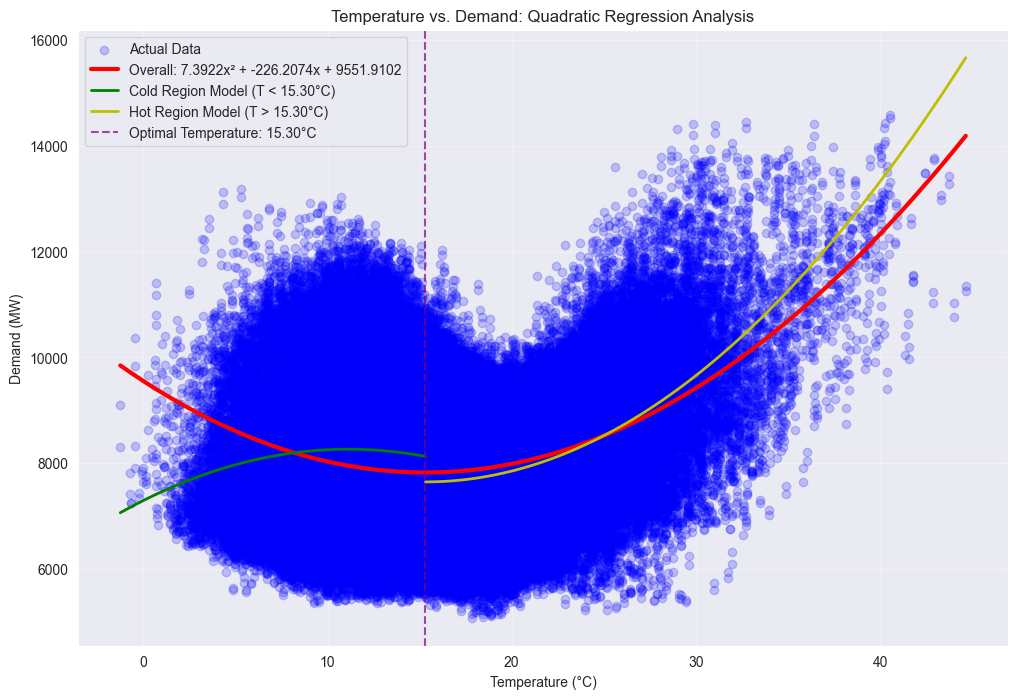

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# File paths
demand_path = r"C:\Users\waseem\Desktop\UNSW\Graduation Project\totaldemand_nsw.csv" # Change path
temperature_path = r"C:\Users\waseem\Desktop\UNSW\Graduation Project\temperature_nsw.csv" # change path

# Load data

demand_df = pd.read_csv(demand_path)
temperature_df = pd.read_csv(temperature_path)

print(f"Demand data: {len(demand_df)} rows")
print(f"Temperature data: {len(temperature_df)} rows")

# Display sample data
print("\nSample demand data:")
print(demand_df.head())
print("\nSample temperature data:")
print(temperature_df.head())

# Convert date formats for matching
print("\nPreparing datetime formats for matching...")

def convert_demand_datetime(demand_datetime):
    """Convert demand datetime to a standard format"""
    try:
        dt = datetime.strptime(demand_datetime, '%d/%m/%Y %H:%M')
        return dt.strftime('%Y-%m-%d %H:%M')
    except:
        return demand_datetime

def convert_temp_datetime(temp_datetime):
    """Convert temperature datetime to a standard format"""
    try:
        dt = datetime.strptime(temp_datetime, '%d/%m/%Y %H:%M')
        return dt.strftime('%Y-%m-%d %H:%M')
    except:
        try:
            # Try alternative format if the first one fails
            dt = datetime.strptime(temp_datetime, '%d/%m/%Y %H:%M:%S')
            return dt.strftime('%Y-%m-%d %H:%M')
        except:
            return temp_datetime

# Add standardized datetime columns
demand_df['DATETIME_STD'] = demand_df['DATETIME'].apply(convert_demand_datetime)
temperature_df['DATETIME_STD'] = temperature_df['DATETIME'].apply(convert_temp_datetime)


# We'll create an hourly aggregation to match with demand data
print("\nAggregating temperature data to match demand timestamps...")

# Extract hour component for grouping
temperature_df['HOUR'] = temperature_df['DATETIME_STD'].apply(
    lambda x: x[:13] if len(x) >= 13 else x  # Get YYYY-MM-DD HH part
)

# Aggregate temperature by hour (average if multiple readings per hour)
hourly_temp = temperature_df.groupby(['HOUR', 'LOCATION'])['TEMPERATURE'].mean().reset_index()
print(f"Aggregated temperature data: {len(hourly_temp)} rows")

# Now match demand with temperature based on datetime
print("\nMatching demand with temperature data...")

# Extract hour component from demand timestamps too
demand_df['HOUR'] = demand_df['DATETIME_STD'].apply(
    lambda x: x[:13] if len(x) >= 13 else x  # Get YYYY-MM-DD HH part
)

# Merge demand with temperature
merged_df = pd.merge(
    demand_df,
    hourly_temp,
    left_on='HOUR',
    right_on='HOUR',
    how='inner'
)

print(f"Matched data: {len(merged_df)} rows")

# If the merge didn't work well, try a different approach
if len(merged_df) < len(demand_df) * 0.5:  # Less than 50% matched
    print("Low match rate. Trying alternative approach...")

    # Create a date-only field for matching by day
    demand_df['DATE'] = demand_df['DATETIME_STD'].apply(lambda x: x[:10] if len(x) >= 10 else None)
    temperature_df['DATE'] = temperature_df['DATETIME_STD'].apply(lambda x: x[:10] if len(x) >= 10 else None)

    # Calculate daily average temperature
    daily_temp = temperature_df.groupby(['DATE', 'LOCATION'])['TEMPERATURE'].mean().reset_index()

    # Merge by date
    merged_df = pd.merge(
        demand_df,
        daily_temp,
        on='DATE',
        how='inner'
    )

    print(f"Date-based match: {len(merged_df)} rows")

# Basic statistics
print("\nBasic statistics:")
print(f"Correlation between Temperature and Demand: {merged_df['TEMPERATURE'].corr(merged_df['TOTALDEMAND']):.4f}")

# Calculate statistics by temperature ranges with equal sample sizes
print("\nCreate temperature ranges with approximately equal sample sizes:")
# Determine the number of ranges (bins)
num_ranges = 10  # You can adjust this number

# Use quantile-based binning to create ranges with equal sample sizes
quantiles = np.linspace(0, 1, num_ranges+1)
temp_quantiles = [merged_df['TEMPERATURE'].quantile(q) for q in quantiles]
temp_quantiles[0] = temp_quantiles[0] - 0.1  # Ensure the lowest temperature is included

# Create labels for these ranges
equal_size_labels = [f'{temp_quantiles[i]:.1f}-{temp_quantiles[i+1]:.1f}°C' for i in range(num_ranges)]

# Cut the temperature data into these ranges
merged_df['TEMP_RANGE_EQUAL'] = pd.cut(
    merged_df['TEMPERATURE'],
    bins=temp_quantiles,
    labels=equal_size_labels,
    include_lowest=True
)

# Group by equal-sized temperature ranges
demand_by_equal_temp = merged_df.groupby('TEMP_RANGE_EQUAL')['TOTALDEMAND'].agg(
    ['mean', 'std', 'count']
).reset_index()
print("Temperature ranges with equal sample sizes:")
print(demand_by_equal_temp)

# Visualizations
print("\nCreating visualizations...")

# 1. Scatter plot of Temperature vs Demand with quadratic regression
plt.figure(figsize=(10, 6))
plt.scatter(merged_df['TEMPERATURE'], merged_df['TOTALDEMAND'], alpha=0.5)
plt.title('Relationship between Temperature and Electricity Demand')
plt.xlabel('Temperature (°C)')
plt.ylabel('Total Demand (MW)')
plt.grid(True, alpha=0.3)

# Add quadratic regression line
z = np.polyfit(merged_df['TEMPERATURE'], merged_df['TOTALDEMAND'], 2)  # Quadratic fit
p = np.poly1d(z)
temp_range = np.linspace(merged_df['TEMPERATURE'].min(), merged_df['TEMPERATURE'].max(), 100)
plt.plot(temp_range, p(temp_range), "r--", linewidth=2, label=f'Quadratic Fit: {z[0]:.4f}x² + {z[1]:.4f}x + {z[2]:.4f}')
plt.legend()

# Calculate and show R-squared for the quadratic model
from sklearn.metrics import r2_score
y_actual = merged_df['TOTALDEMAND']
x_data = merged_df['TEMPERATURE']
y_pred = z[0] * x_data**2 + z[1] * x_data + z[2]
r2 = r2_score(y_actual, y_pred)
plt.annotate(f'R² = {r2:.4f}', xy=(0.05, 0.95), xycoords='axes fraction',
             fontsize=10, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

plt.savefig('temperature_vs_demand_scatter.png')

# 2. Average Demand by Temperature Range (equal sample sizes)
plt.figure(figsize=(12, 6))
sns.barplot(x='TEMP_RANGE_EQUAL', y='mean', data=demand_by_equal_temp)
plt.title('Average Electricity Demand by Temperature Range (Equal Sample Sizes)')
plt.xlabel('Temperature Range')
plt.ylabel('Average Demand (MW)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('avg_demand_by_equal_temp_range.png')

# 3. Time series plot of temperature and demand (sample period)
if len(merged_df) > 0:
    # Sort by datetime
    if 'DATETIME_STD' in merged_df.columns:
        merged_df['DATETIME_OBJ'] = pd.to_datetime(merged_df['DATETIME_STD'])
        merged_df = merged_df.sort_values('DATETIME_OBJ')

    # Get a sample period (first 7 days or less)
    sample_period = merged_df.iloc[:min(24*7, len(merged_df))]

    # Create the time series plot
    fig, ax1 = plt.subplots(figsize=(14, 7))

    # Plot demand
    color = 'tab:blue'
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Demand (MW)', color=color)
    ax1.plot(sample_period['DATETIME_OBJ'], sample_period['TOTALDEMAND'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Create second y-axis for temperature
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Temperature (°C)', color=color)
    ax2.plot(sample_period['DATETIME_OBJ'], sample_period['TEMPERATURE'], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title('Temperature and Demand Over Time')
    fig.tight_layout()
    plt.savefig('temperature_demand_time_series.png')

print("\nAnalysis complete. Visualizations saved.")

# Additional insights
print("\nKey Findings:")
print(f"1. Overall correlation between temperature and demand: {merged_df['TEMPERATURE'].corr(merged_df['TOTALDEMAND']):.4f}")

# Quadratic regression coefficients
z = np.polyfit(merged_df['TEMPERATURE'], merged_df['TOTALDEMAND'], 2)
p = np.poly1d(z)
print(f"2. Quadratic regression equation: {z[0]:.4f}x² + {z[1]:.4f}x + {z[2]:.4f}")

# Calculate R-squared for the quadratic model
from sklearn.metrics import r2_score
y_actual = merged_df['TOTALDEMAND']
x_data = merged_df['TEMPERATURE']
y_pred = z[0] * x_data**2 + z[1] * x_data**2 + z[2]
r2 = r2_score(y_actual, y_pred)
print(f"3. R-squared value for quadratic model: {r2:.4f}")

# Calculate optimal temperature (vertex of parabola)
optimal_temp = -z[1] / (2*z[0])
print(f"4. Optimal temperature (minimum demand point): {optimal_temp:.2f}°C")

# Calculate separate correlations for hot and cold temperatures
cold_df = merged_df[merged_df['TEMPERATURE'] < optimal_temp]
hot_df = merged_df[merged_df['TEMPERATURE'] > optimal_temp]

cold_corr = cold_df['TEMPERATURE'].corr(cold_df['TOTALDEMAND'])
hot_corr = hot_df['TEMPERATURE'].corr(hot_df['TOTALDEMAND'])

print(f"5. Correlation in cold temperatures (below {optimal_temp:.2f}°C): {cold_corr:.4f}")
print(f"6. Correlation in hot temperatures (above {optimal_temp:.2f}°C): {hot_corr:.4f}")

# Calculate correlation for extreme temperatures (<5°C and >30°C)
extreme_cold_df = merged_df[merged_df['TEMPERATURE'] < 5]
extreme_hot_df = merged_df[merged_df['TEMPERATURE'] > 30]

extreme_cold_corr = extreme_cold_df['TEMPERATURE'].corr(extreme_cold_df['TOTALDEMAND']) if len(extreme_cold_df) > 2 else float('nan')
extreme_hot_corr = extreme_hot_df['TEMPERATURE'].corr(extreme_hot_df['TOTALDEMAND']) if len(extreme_hot_df) > 2 else float('nan')

print(f"7. Correlation in extreme temperatures:")
print(f"   - Cold (<5°C): {extreme_cold_corr:.4f}" if not np.isnan(extreme_cold_corr) else "   - Cold (<5°C): Not enough data")
print(f"   - Hot (>30°C): {extreme_hot_corr:.4f}" if not np.isnan(extreme_hot_corr) else "   - Hot (>30°C): Not enough data")

# Calculate quadratic models for cold and hot regions separately
if len(cold_df) > 10:
    cold_z = np.polyfit(cold_df['TEMPERATURE'], cold_df['TOTALDEMAND'], 2)
    cold_r2 = r2_score(cold_df['TOTALDEMAND'],
                       cold_z[0] * cold_df['TEMPERATURE']**2 + cold_z[1] * cold_df['TEMPERATURE'] + cold_z[2])
    print(f"8. Cold region quadratic model (T < {optimal_temp:.2f}°C):")
    print(f"   - Equation: {cold_z[0]:.4f}x² + {cold_z[1]:.4f}x + {cold_z[2]:.4f}")
    print(f"   - R-squared: {cold_r2:.4f}")

if len(hot_df) > 10:
    hot_z = np.polyfit(hot_df['TEMPERATURE'], hot_df['TOTALDEMAND'], 2)
    hot_r2 = r2_score(hot_df['TOTALDEMAND'],
                      hot_z[0] * hot_df['TEMPERATURE']**2 + hot_z[1] * hot_df['TEMPERATURE'] + hot_z[2])
    print(f"9. Hot region quadratic model (T > {optimal_temp:.2f}°C):")
    print(f"   - Equation: {hot_z[0]:.4f}x² + {hot_z[1]:.4f}x + {hot_z[2]:.4f}")
    print(f"   - R-squared: {hot_r2:.4f}")

# Create a new plot showing original data and quadratic model fit
plt.figure(figsize=(12, 8))

# Scatter plot of actual data
plt.scatter(merged_df['TEMPERATURE'], merged_df['TOTALDEMAND'], alpha=0.2, color='blue', label='Actual Data')

# Sort temperatures for smooth curve plotting
temp_sorted = np.sort(merged_df['TEMPERATURE'].unique())

# Plot overall quadratic model
overall_curve = z[0] * temp_sorted**2 + z[1] * temp_sorted + z[2]
plt.plot(temp_sorted, overall_curve, 'r-', linewidth=3, label=f'Overall: {z[0]:.4f}x² + {z[1]:.4f}x + {z[2]:.4f}')

# Create and plot separate models for cold and hot regions
if len(cold_df) > 10:
    cold_temps = np.sort(cold_df['TEMPERATURE'].unique())
    cold_z = np.polyfit(cold_df['TEMPERATURE'], cold_df['TOTALDEMAND'], 2)
    cold_curve = cold_z[0] * cold_temps**2 + cold_z[1] * cold_temps + cold_z[2]
    plt.plot(cold_temps, cold_curve, 'g-', linewidth=2, label=f'Cold Region Model (T < {optimal_temp:.2f}°C)')

if len(hot_df) > 10:
    hot_temps = np.sort(hot_df['TEMPERATURE'].unique())
    hot_z = np.polyfit(hot_df['TEMPERATURE'], hot_df['TOTALDEMAND'], 2)
    hot_curve = hot_z[0] * hot_temps**2 + hot_z[1] * hot_temps + hot_z[2]
    plt.plot(hot_temps, hot_curve, 'y-', linewidth=2, label=f'Hot Region Model (T > {optimal_temp:.2f}°C)')

# Add vertical line at optimal temperature
plt.axvline(x=optimal_temp, color='purple', linestyle='--', alpha=0.7,
            label=f'Optimal Temperature: {optimal_temp:.2f}°C')

plt.title('Temperature vs. Demand: Quadratic Regression Analysis')
plt.xlabel('Temperature (°C)')
plt.ylabel('Demand (MW)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.savefig('temperature_demand_quadratic_models.png')

print("\nCalculated demand at various temperatures using the quadratic model:")
for temp in [0, 5, 10, 15, 20, 25, 30, 35]:
    predicted_demand = z[0] * temp**2 + z[1] * temp + z[2]
    print(f"  At {temp}°C: {predicted_demand:.2f} MW")

